# Prevalence of people with rCSI >= 19 released by World Food Programme (WFP)

In this notebook, we create the time-series regarding the **Reduced Coping Strategy Index (rCSI)** indicator. In particular, these time-series will describe the prevalence of people with rCSI >= 19.

For more details, see the *README.md*.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import pandas as pd
import numpy as np
import ntpath
import glob
plt.style.use("default")

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../../packages/")
from MapPlot.MapPlot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
# Read the data released by wfp regarding the prevalence of people with rCSI >= 19 stored in the 'WFP_data' folder.
path = "./WFP_data/"
all_folders = glob.glob(path + "*")

dfs = []

for folder in all_folders:
    country = ntpath.basename(folder).split(".")[0]
    all_files = glob.glob(path + country + "/*.csv")
    for filename in all_files:
        df = pd.read_csv(filename)
        df["Country"] = country
        dfs.append(df)

In [5]:
# Concatenate data.
df = pd.concat(dfs, axis = 0, ignore_index = True)
# Delete duplicate rows if exist.
df = df.drop_duplicates()
df.head()

,SvyDate,Date,Dmgrph,DmgrphCode,Mean_crrnt,Pop,PopNmbr,Country
0,2019-7-15_2019-9-8,2019-09-08,CASCADES,900713,8.43056,755896,63726,Burkina Faso
1,2019-7-15_2019-9-8,2019-09-08,CENTRE-OUEST,900717,14.90000,1510412,225051,Burkina Faso
2,2019-7-15_2019-9-8,2019-09-08,NORD,900721,22.71170,1500082,340693,Burkina Faso
3,2019-7-15_2019-9-8,2019-09-08,CENTRE,900714,7.58997,2623394,199114,Burkina Faso
4,2019-7-15_2019-9-8,2019-09-08,CENTRE-SUD,900718,12.38490,801374,99249,Burkina Faso


### Brief items description

- *SvyDate*: reference period of the data collection;
- *Date*: reference date (i.e. the end of the reference period);
- *Dmgrph*: administrative area name;
- *DmgrphCode*: a code for identyfing the adminstrata;
- *Mean_crrnt*: corresponds to the % of people with rCSI >= 19 during the corresponding SvyDate; 
- *Pop*: area population size;
- *PopNmbr*: number of people with rCSI >= 19;
- *Country*: country name;

N.B. For simplicity in the following we will indicate the prevalence of people with rCSI >= 19 with the 'rCSI' notation only.

In [6]:
# Check if the dataframe contains NaN values.
df.isnull().sum()

SvyDate       0
Date          0
Dmgrph        0
DmgrphCode    0
Mean_crrnt    0
Pop           0
PopNmbr       0
Country       0
dtype: int64

In [7]:
# Let's delete some items because they are not of interest in this notebook.
df.drop(["DmgrphCode", "Pop", "PopNmbr"], axis = 1, inplace = True) 

In [8]:
# Rename some columns items.
df.rename(columns = {"Date": "Datetime", "Dmgrph": "AdminStrata", "Mean_crrnt": "rCSI"}, inplace = True)

In [9]:
# Check the temporal ranges of the SvyDate column based on country creating two new columns.
df[["SvyDate1", "SvyDate2"]] = df["SvyDate"].apply(lambda x: pd.Series([pd.to_datetime(x.split("_")[0]), pd.to_datetime(x.split("_")[1])]))
# The new column 'SvyDateRange' indicates the coverage of days of the survey [SvyDate1, SvyDate2].
df["SvyDateRange"] = (df["SvyDate2"] - df["SvyDate1"]).dt.days + 1
df.head()

,SvyDate,Datetime,AdminStrata,rCSI,Country,SvyDate1,SvyDate2,SvyDateRange
0,2019-7-15_2019-9-8,2019-09-08,CASCADES,8.43056,Burkina Faso,2019-07-15,2019-09-08,56
1,2019-7-15_2019-9-8,2019-09-08,CENTRE-OUEST,14.90000,Burkina Faso,2019-07-15,2019-09-08,56
2,2019-7-15_2019-9-8,2019-09-08,NORD,22.71170,Burkina Faso,2019-07-15,2019-09-08,56
3,2019-7-15_2019-9-8,2019-09-08,CENTRE,7.58997,Burkina Faso,2019-07-15,2019-09-08,56
4,2019-7-15_2019-9-8,2019-09-08,CENTRE-SUD,12.38490,Burkina Faso,2019-07-15,2019-09-08,56


In [10]:
# Check what are the temporal coverages of countries.
df.groupby("Country")["SvyDateRange"].unique()

Country
Burkina Faso        [56, 30]
Cameroon            [30, 90]
Mali            [28, 84, 30]
Niger               [28, 84]
Nigeria             [31, 30]
Syria                   [31]
Yemen                   [31]
Name: SvyDateRange, dtype: object

This information about the survey coverage will be useful when adapting the time-series of other indicators (see other notebooks) to this coverage format. The survey coverage of the rCSI >= 19 indicator is identical to the survey coverage of the FCG indicator for all the countries.

### Country item

In [11]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Burkina Faso, Cameroon, Mali, Niger, Nigeria, Syria, Yemen


### AdminStrata item

In [12]:
# The strings of the administrative regions of Burkina Faso, we change them to obtain lowercase with first capital letter.
def to_lower(country, admin):
    if country in ["Burkina Faso", "Cameroon", "Mali", "Niger"]:
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

In [13]:
# Rename some regions.
df.replace(["Tombouctou/Taoudeni", "Gao/Menaka"], ["Tombouctou-Taoudeni", "Gao-Menaka"], inplace = True)

In [14]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen (YEM)**: the administrative regions of Yemen are 22, including the capital Sana'a (Amanat Al Asimah) and Socotra archipelago. The rCSI dataframe has the values of all the 22 administrative regions.

N.B. Hadramaut and Socotra have identical time-series related to rCSI indicator.

In [15]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", 'Al Hudaydah',
       'Al Jawf', 'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran',
       'Dhamar', 'Hadramaut', 'Socotra', 'Hajjah', 'Ibb', 'Lahj', 'Marib',
       'Raymah', "Sa'ada", "Sana'a", 'Shabwah', 'Taizz'], dtype=object)

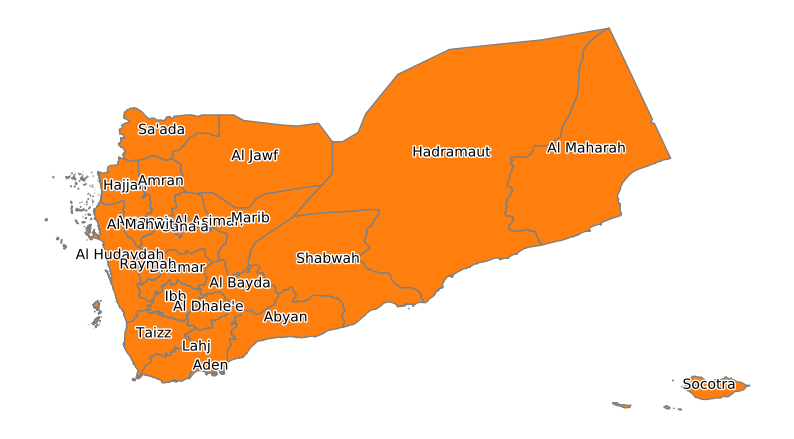

In [16]:
# Plot map.
draw_adminstratas(country = "Yemen", adminstratas = AdminStratas["Yemen"], adminstratas_to_highlight = AdminStratas["Yemen"],
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Yemen/administrative_level_1/Yemen.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Yemen/map_rcsi_yemen.png", 
                  dpi = 300)

- **Burkina Faso (BFA)**: Burkina Faso is divided into 13 administrative regions. The FCG <= 2 dataframe has the values of all 13 administrative regions.

In [17]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Cascades', 'Centre-Ouest', 'Nord', 'Centre', 'Centre-Sud',
       'Plateau-Central', 'Centre-Est', 'Est', 'Sahel',
       'Boucle-Du-Mouhoun', 'Centre-Nord', 'Hauts-Bassins', 'Sud-Ouest'],
      dtype=object)

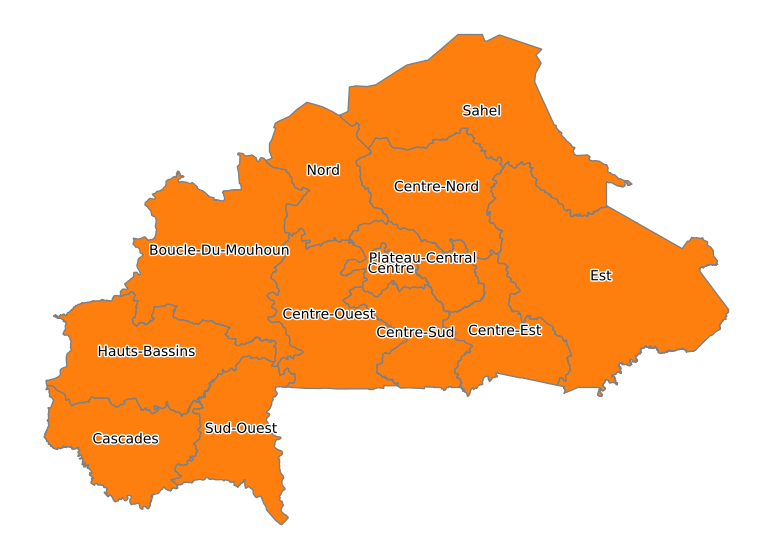

In [18]:
# Plot map.
draw_adminstratas(country = "Burkina Faso", adminstratas = AdminStratas["Burkina Faso"], adminstratas_to_highlight = AdminStratas["Burkina Faso"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Burkina Faso/administrative_level_1/Burkina Faso.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Burkina Faso/map_rcsi_burkina.png", 
                  dpi = 300)

- **Syria (SYR)**: the administrative regions of the Syria country are 14. The rCSI >= 19 dataframe has the values of 13 administrative regions (Idleb administrative region not included).

In [19]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Al-Hasakeh', 'Aleppo', 'As-Sweida', 'Damascus', "Dar'a", 'Hama',
       'Homs', 'Lattakia', 'Rural Damascus', 'Tartous', 'Ar-Raqqa',
       'Deir-ez-Zor', 'Quneitra'], dtype=object)

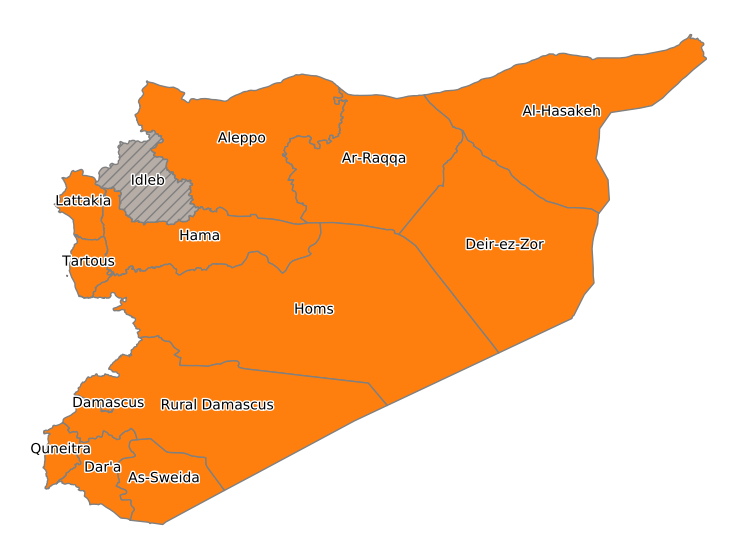

In [20]:
# Plot map.
draw_adminstratas(country = "Syria", adminstratas = AdminStratas["Syria"], adminstratas_to_highlight = AdminStratas["Syria"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Syria/administrative_level_1/Syria.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Syria/map_rcsi_syria.png", 
                  dpi = 300)

- **Cameroon (CMR)**: the administrative regions of Cameroon are 10. The rCSI >= 19 dataframe has the values of all the 10 administrative regions.

In [21]:
print(AdminStratas["Cameroon"].shape)
AdminStratas["Cameroon"]

(10,)


array(['North-West', 'South-West', 'Adamawa', 'Central', 'East',
       'Far-North', 'Littoral', 'North', 'South', 'West'], dtype=object)

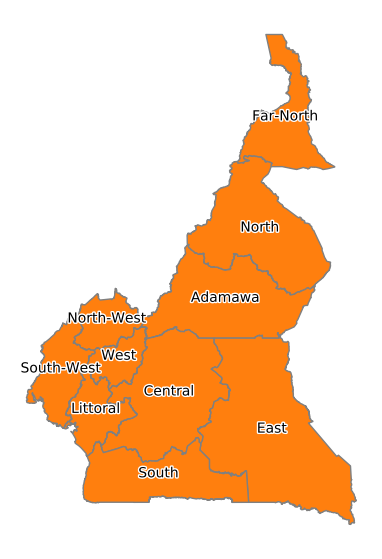

In [22]:
# Plot map.
draw_adminstratas(country = "Cameroon", adminstratas = AdminStratas["Cameroon"], adminstratas_to_highlight = AdminStratas["Cameroon"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Cameroon/administrative_level_1/Cameroon.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Cameroon/map_rcsi_cameroon.png", 
                  dpi = 300)

- **Mali (MLI)**: Mali is divided into eight regions and one capital district (Bamako). The AdminStrata items of the rCSI >= 19 dataframe cover all 9 regions.

In [23]:
print(AdminStratas["Mali"].shape)
AdminStratas["Mali"]

(9,)


array(['Mopti', 'Segou', 'Tombouctou-Taoudeni', 'Bamako', 'Kayes',
       'Koulikoro', 'Sikasso', 'Gao-Menaka', 'Kidal'], dtype=object)

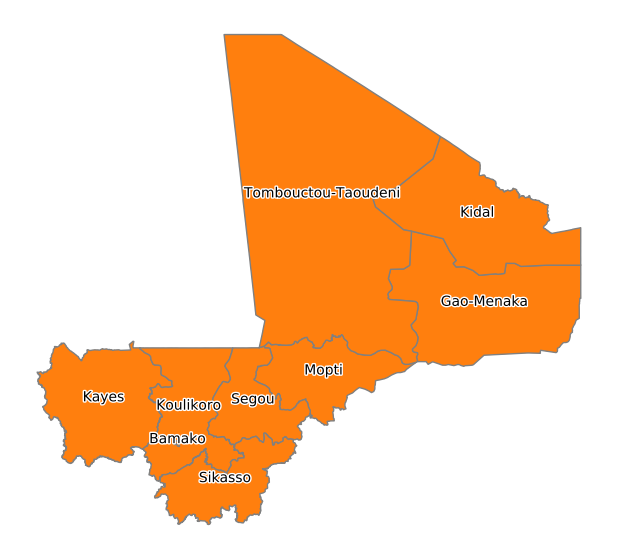

In [24]:
# Plot map.
draw_adminstratas(country = "Mali", adminstratas = AdminStratas["Mali"], adminstratas_to_highlight = AdminStratas["Mali"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Mali/administrative_level_1/Mali.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Mali/map_rcsi_mali.png", 
                  dpi = 300)

- **Niger (NER)**: the administrative regions of Niger are 8. The rCSI >= 19 dataframe has the values of all the 8 administrative regions.

In [25]:
print(AdminStratas["Niger"].shape)
AdminStratas["Niger"]

(8,)


array(['Diffa', 'Maradi', 'Tahoua', 'Tillaberi', 'Agadez', 'Dosso',
       'Niamey', 'Zinder'], dtype=object)

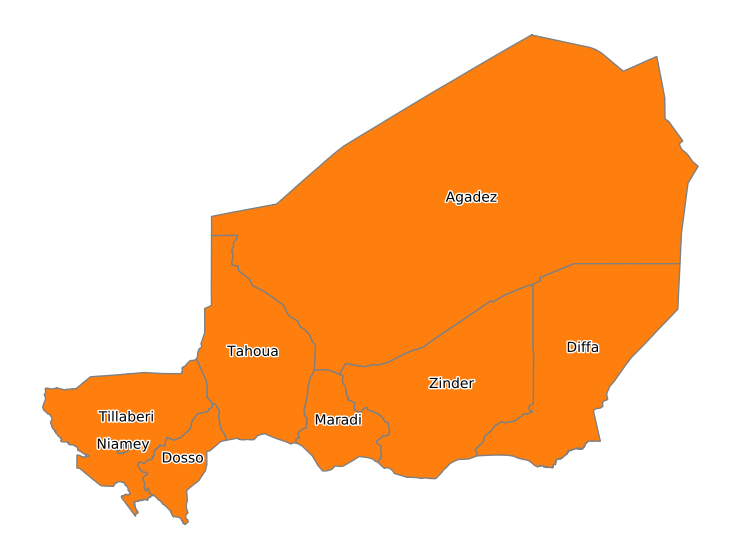

In [26]:
# Plot map.
draw_adminstratas(country = "Niger", adminstratas = AdminStratas["Niger"], adminstratas_to_highlight = AdminStratas["Niger"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Niger/administrative_level_1", figsize = (10, 7), annotation = True, 
                  annotation_selected = True, path_to_save = PATH_TO_SAVE_DATA + "Niger/map_rcsi_niger.png", dpi = 300)

- **Nigeria (NGA)**: Nigeria is divided into 36 administrative regions. It also includes The Federal Capital Territory that is is under the direct control of the federal government. The AdminStrata items of the rCSI >= 19 dataframe cover 3 administrative regions: Adamawa, Borno and Yobe.

In [27]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(3,)


array(['Adamawa', 'Borno', 'Yobe'], dtype=object)

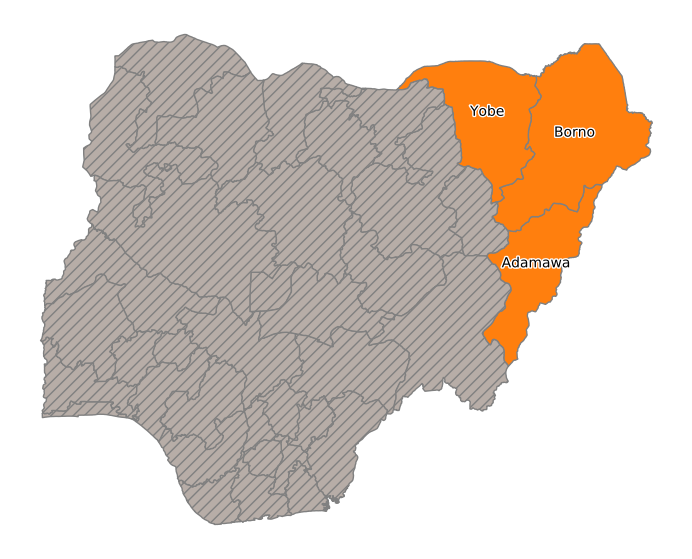

In [28]:
# Plot map.
draw_adminstratas(country = "Nigeria", adminstratas = AdminStratas["Nigeria"], adminstratas_to_highlight = AdminStratas["Nigeria"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Nigeria/administrative_level_1", 
                  figsize = (10, 7), annotation = True, annotation_selected = True, path_to_save = PATH_TO_SAVE_DATA + "Nigeria/map_rcsi_nigeria.png", 
                  dpi = 300)

## Data analysis

In [29]:
# Check the min e max values of the rCSI column (% of people with rCSI).
print("min: %f, max: %f" % (df["rCSI"].min(), df["rCSI"].max()))

min: 0.000000, max: 99.974600


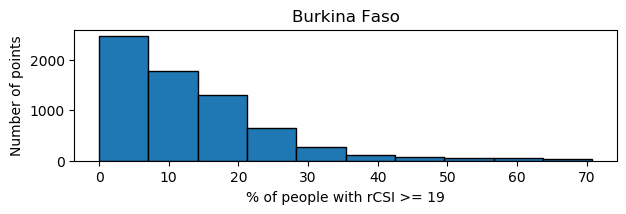

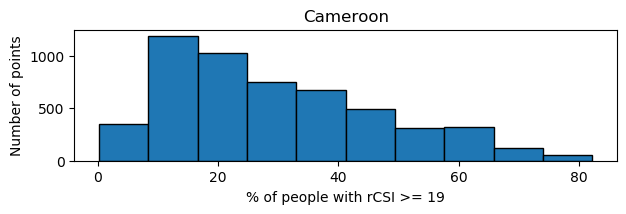

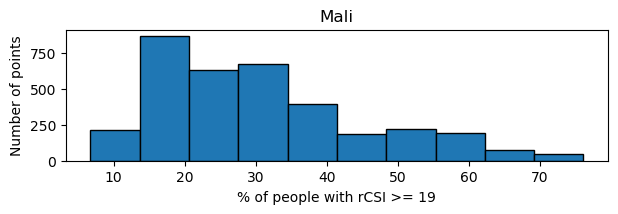

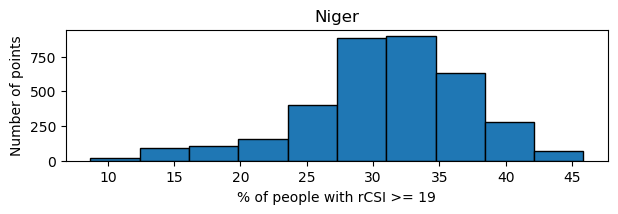

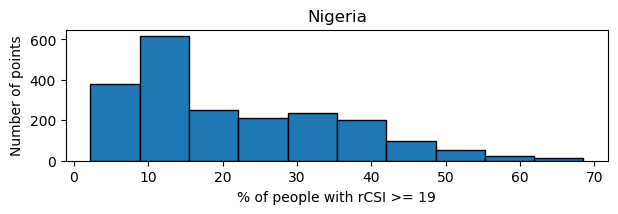

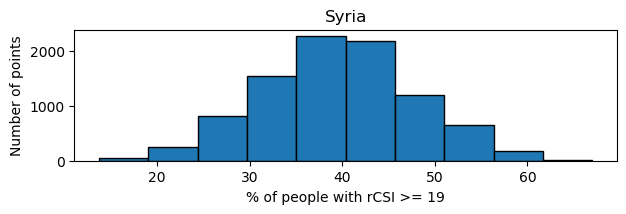

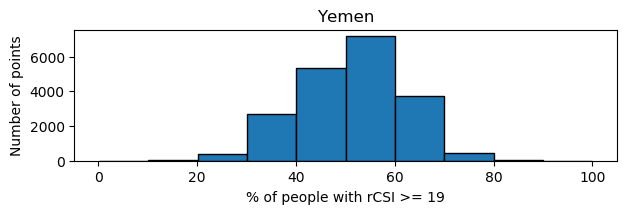

In [30]:
# Create an histogram referred to the values of the metric for each country.
def hist_rcsi(group):
    # Plot hist.
    fig, ax = plt.subplots(figsize = (7, 1.7))
    data = group["rCSI"].dropna().values
    ax.hist(data, ec = "k")
    ax.set_title(group.name)
    ax.set_ylabel("Number of points")
    ax.set_xlabel("% of people with rCSI >= 19")
    plt.show()

df.groupby("Country").apply(hist_rcsi);

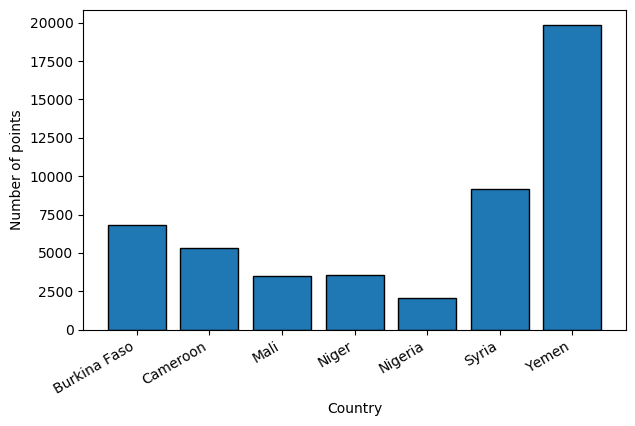

In [31]:
# Create an histogram referred to the number of total points for each country.
n_points = df.groupby("Country")["rCSI"].count()

fig, ax = plt.subplots(figsize = (7, 4.7))
ax.bar(n_points.index, n_points.values, ec = "k")
ax.set_ylabel("Number of points")
ax.set_xlabel("Country")
fig.autofmt_xdate()
plt.show()

## Creation of the time-series

We create the time-series based on the rCSI and SvyDateRange values.

In [32]:
not_unique = df.set_index(["Country", "AdminStrata", "Datetime"])
not_unique.index.is_unique

False

In [33]:
mask = not_unique.index.value_counts() > 1
mask = mask[mask].index

not_unique.loc[mask]

SvyDate       rCSI   SvyDate1  \
Country AdminStrata    Datetime                                                
Syria   Tartous        2020-07-02    2020-6-2_2020-7-2  34.001572 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  33.605284 2020-06-02   
        Homs           2020-08-24  2020-7-25_2020-8-24  38.921328 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  39.184962 2020-07-25   
        Ar-Raqqa       2020-08-24  2020-7-25_2020-8-24  44.777458 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  45.133146 2020-07-25   
        Hama           2020-08-24  2020-7-25_2020-8-24  40.590999 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  39.999576 2020-07-25   
        Dar'a          2020-08-24  2020-7-25_2020-8-24  44.817516 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  45.026803 2020-07-25   
        Al-Hasakeh     2020-07-02    2020-6-2_2020-7-2  56.850716 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  57.450980 2020-06-02   
        Damascus       2020-08-24  2020-7-25_2020-8-24  39.897340 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  40.918690 2020-07-25   
        Rural Damascus 2020-07-02    2020-6-2_2020-7-2  45.097487 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  44.957063 2020-06-02   
        Damascus       2020-07-02    2020-6-2_2020-7-2  34.733728 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  34.733728 2020-06-02   
        Deir-ez-Zor    2020-07-02    2020-6-2_2020-7-2  37.122369 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  38.277949 2020-06-02   
                       2020-08-24  2020-7-25_2020-8-24  53.820535 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  53.678199 2020-07-25   
        Quneitra       2020-07-02    2020-6-2_2020-7-2  42.124542 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  43.369176 2020-06-02   
        Dar'a          2020-07-02    2020-6-2_2020-7-2  46.467632 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  45.636534 2020-06-02   
        Ar-Raqqa       2020-07-02    2020-6-2_2020-7-2  37.122369 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  38.277949 2020-06-02   
        Rural Damascus 2020-08-24  2020-7-25_2020-8-24  39.913865 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  40.176187 2020-07-25   
        Aleppo         2020-08-24  2020-7-25_2020-8-24  41.316852 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  40.886133 2020-07-25   

                                    SvyDate2  SvyDateRange  
Country AdminStrata    Datetime                             
Syria   Tartous        2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Homs           2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Ar-Raqqa       2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Hama           2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Dar'a          2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Al-Hasakeh     2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Damascus       2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Rural Damascus 2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Damascus       2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Deir-ez-Zor    2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02 

In [34]:
# Delete the unused columns.
df.drop(["SvyDate", "SvyDate1", "SvyDate2"], axis = 1, inplace = True) 
# Creation of an accurate datetime format.
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", ascending = True, inplace = True) 
# Create time-series.
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,rCSI,SvyDateRange
0,Burkina Faso,Boucle-Du-Mouhoun,2019-09-08,19.4995,56.0
1,Burkina Faso,Boucle-Du-Mouhoun,2019-09-09,19.5674,56.0
2,Burkina Faso,Boucle-Du-Mouhoun,2019-09-10,20.4007,56.0
3,Burkina Faso,Boucle-Du-Mouhoun,2019-09-11,20.4056,56.0
4,Burkina Faso,Boucle-Du-Mouhoun,2019-09-12,19.2385,56.0


In [35]:
# Create a dataframe with multi-index column in order to have a summary dataframe of the time-series.
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"]).reorder_levels([1, 2, 0], axis = 1).sort_index(axis = 1, level = [0, 1, 2])
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq
df.head()

Country          Burkina Faso                                           \
AdminStrata Boucle-Du-Mouhoun          Cascades            Centre        
Indicator        SvyDateRange rCSI SvyDateRange rCSI SvyDateRange rCSI   
Datetime                                                                 
2018-08-22                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-23                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-24                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-25                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-26                NaN  NaN          NaN  NaN          NaN  NaN   

Country                                          ...        Yemen           \
AdminStrata   Centre-Est       Centre-Nord       ...       Sa'ada            
Indicator   SvyDateRange rCSI SvyDateRange rCSI  ... SvyDateRange     rCSI   
Datetime                                         ...                         
2018-08-22           NaN  NaN          NaN  NaN  ...         31.0  46.4355   
2018-08-23           NaN  NaN          NaN  NaN  ...         31.0  45.2619   
2018-08-24           NaN  NaN          NaN  NaN  ...         31.0  44.5205   
2018-08-25           NaN  NaN          NaN  NaN  ...         31.0  46.3459   
2018-08-26           NaN  NaN          NaN  NaN  ...         31.0  43.2946   

Country                                                                        \
AdminStrata       Sana'a               Shabwah               Socotra            
Indicator   SvyDateRange     rCSI SvyDateRange     rCSI SvyDateRange     rCSI   
Datetime                                                                        
2018-08-22          31.0  52.6679         31.0  34.3022         31.0  38.3031   
2018-08-23          31.0  50.2146         31.0  36.7425         31.0  39.5451   
2018-08-24          31.0  50.0732         31.0  35.8577         31.0  41.8678   
2018-08-25          31.0  48.7917         31.0  34.6584         31.0  48.5856   
2018-08-26          31.0  48.8396         31.0  35.9131         31.0  48.6624   

Country                            
AdminStrata        Taizz           
Indicator   SvyDateRange     rCSI  
Datetime                           
2018-08-22          31.0  50.9190  
2018-08-23          31.0  50.4159  
2018-08-24          31.0  49.3913  
2018-08-25          31.0  50.3024  
2018-08-26          31.0  50.2930  

[5 rows x 156 columns]

In [36]:
# Plot time-series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [37]:
def full_extent(ax, pad = 0.0):
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

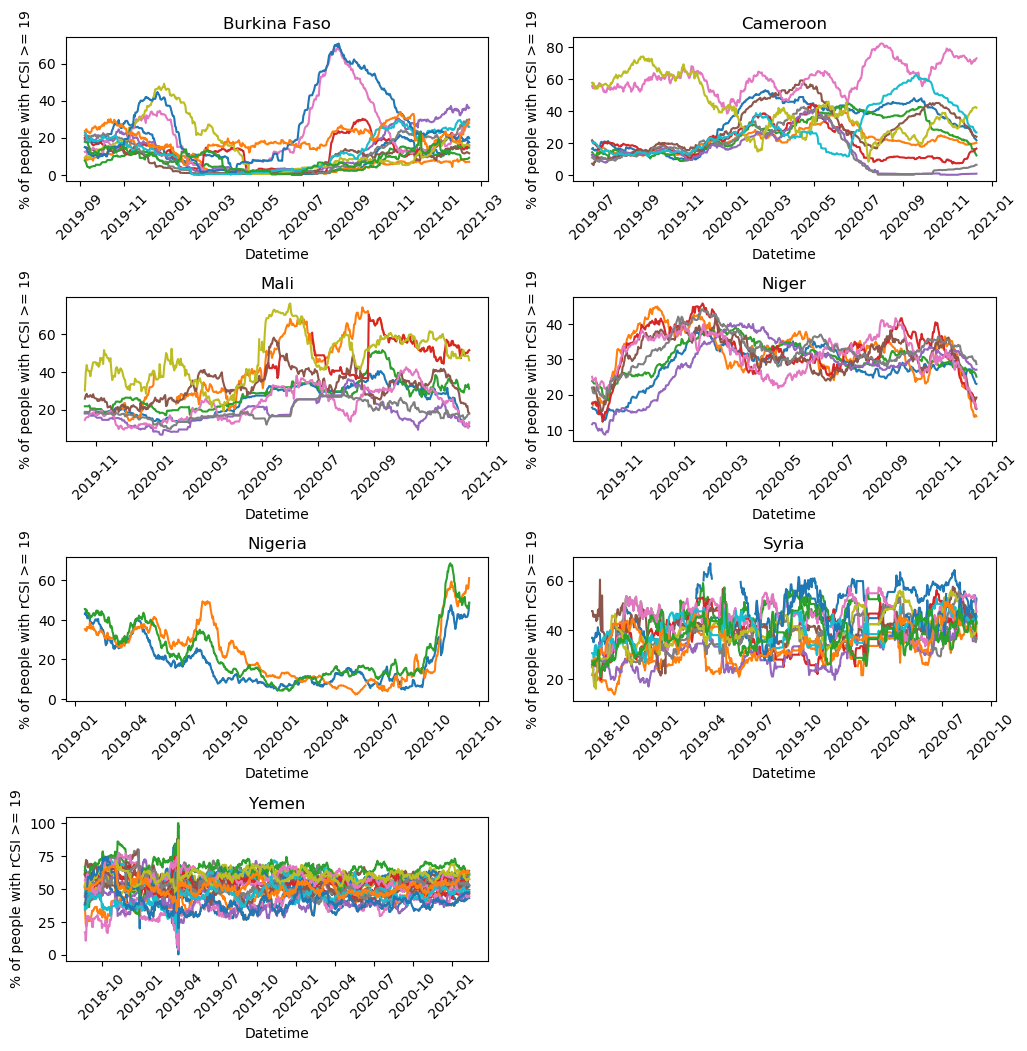

In [38]:
# Plot the original time-series of the rCSI indicator for each country.
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 12))
fig.subplots_adjust(hspace = 0.8)
axs = axs.ravel()
for i, country in enumerate(df.columns.get_level_values(0).unique()):
    axs[i].plot(df[country].xs("rCSI", axis = 1, level = 1, drop_level = False))
    axs[i].set_title(country)
    axs[i].set_xlabel("Datetime")
    axs[i].set_ylabel("% of people with rCSI >= 19")
    axs[i].tick_params(axis = "x", labelrotation = 45)
    # Save just the portion of the current axes.
    extent = full_extent(axs[i]).transformed(fig.dpi_scale_trans.inverted())
    extent = axs[i].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(PATH_TO_SAVE_DATA + "%s/ts_rcsi_%s.png" % (country, country), bbox_inches = extent, dpi = 300)
# Remove extra plot.
axs[-1].set_axis_off()

In [39]:
# Save the figure.
fig.savefig(PATH_TO_SAVE_DATA + "ts.png", dpi = 300)

In [40]:
# Now save the time-series of each country keeping as indeces for each time-series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [41]:
# Save the time-series.
df.xs("rCSI", axis = 1, level = 2, drop_level = False).groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rcsi"));

## Adjustment of the time-series (interpolation NaN values)

Let's interpolate the NaN values between the first and last valid index of each time-series using a linear interpolation up to a limit of 7 days. Finally, we delete the time-series that still have some NaN values in the last temporal points.

In [42]:
# Let's interpolate the NaN values using a linear interpolation up to a limit of 7 days.
def interpolation(group):  
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    group = group.interpolate(method = "linear", limit = 7, axis = 0)
    # Delete time-series that still has some NaN values in its last temporal part.
    if group.isna().any().any():
        # Keep only last temporal part of the time-series.
        events = np.split(group, np.where(np.isnan(group.values))[0])
        # Removing NaN entries.
        events = [ev[~np.isnan(ev.values)] for ev in events if not isinstance(ev, np.ndarray)]
        # Removing empty DataFrames.
        events = [ev for ev in events if not ev.empty]
        # Last event (70%).
        last_event = events[-1]
        if len(last_event) >= int(0.7*len(group)):
            return last_event
        else:
            group.dropna(inplace = True, axis = 1)
            return group
    else:
        return group
    
df_interpolate = df.groupby(axis = 1, level = [0, 1, 2], group_keys = False).apply(interpolation)
df_interpolate.head()

Country          Burkina Faso                                           \
AdminStrata Boucle-Du-Mouhoun          Cascades            Centre        
Indicator        SvyDateRange rCSI SvyDateRange rCSI SvyDateRange rCSI   
Datetime                                                                 
2018-08-22                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-23                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-24                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-25                NaN  NaN          NaN  NaN          NaN  NaN   
2018-08-26                NaN  NaN          NaN  NaN          NaN  NaN   

Country                                          ...        Yemen           \
AdminStrata   Centre-Est       Centre-Nord       ...       Sa'ada            
Indicator   SvyDateRange rCSI SvyDateRange rCSI  ... SvyDateRange     rCSI   
Datetime                                         ...                         
2018-08-22           NaN  NaN          NaN  NaN  ...         31.0  46.4355   
2018-08-23           NaN  NaN          NaN  NaN  ...         31.0  45.2619   
2018-08-24           NaN  NaN          NaN  NaN  ...         31.0  44.5205   
2018-08-25           NaN  NaN          NaN  NaN  ...         31.0  46.3459   
2018-08-26           NaN  NaN          NaN  NaN  ...         31.0  43.2946   

Country                                                                        \
AdminStrata       Sana'a               Shabwah               Socotra            
Indicator   SvyDateRange     rCSI SvyDateRange     rCSI SvyDateRange     rCSI   
Datetime                                                                        
2018-08-22          31.0  52.6679         31.0  34.3022         31.0  38.3031   
2018-08-23          31.0  50.2146         31.0  36.7425         31.0  39.5451   
2018-08-24          31.0  50.0732         31.0  35.8577         31.0  41.8678   
2018-08-25          31.0  48.7917         31.0  34.6584         31.0  48.5856   
2018-08-26          31.0  48.8396         31.0  35.9131         31.0  48.6624   

Country                            
AdminStrata        Taizz           
Indicator   SvyDateRange     rCSI  
Datetime                           
2018-08-22          31.0  50.9190  
2018-08-23          31.0  50.4159  
2018-08-24          31.0  49.3913  
2018-08-25          31.0  50.3024  
2018-08-26          31.0  50.2930  

[5 rows x 154 columns]

In [43]:
# Check what time-series are dropped.
for column in df.columns:
    if column not in df_interpolate.columns:
        print(column)

('Syria', 'Quneitra', 'SvyDateRange')
('Syria', 'Quneitra', 'rCSI')


## Adjustment of March 2019 month for the Yemen country

We remove the values for the month of March 2019 beacuse it seems to have some anomalies. We then replace the values using a simple linear interpolation.

### Remove month

In [44]:
def remove_march_Yemen(group):
    country = group.name[0]
    if country == "Yemen":
        mask = (group.index >= "2019-3-1") & (group.index <= "2019-3-31")
        group.loc[mask] = np.nan    
        return group
    else:
        return group

In [45]:
df_interpolate = df_interpolate.groupby(level = [0, 1], axis = 1, group_keys = False).apply(remove_march_Yemen)

### Replace month

In [46]:
def interpolate_march_Yemen(group):
    country = group.name[0]
    if country == "Yemen":
        mask = (group.index >= "2019-3-1") & (group.index <= "2019-3-31")
        group.loc[mask] = np.nan    
        first_idx = group.first_valid_index()
        last_idx = group.last_valid_index()
        group = group.loc[first_idx:last_idx]
        group = group.interpolate(method = "linear")
        return group
    else:
        return group

In [47]:
df_interpolate = df_interpolate.groupby(level = [0, 1], axis = 1, group_keys = False).apply(interpolate_march_Yemen)

In [48]:
# Plot time-series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [49]:
# Plot time-series without survey coverage information.
TsIP(df_interpolate.xs("rCSI", axis = 1, level = 2, drop_level = False)).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Cameroon', 'Mali', 'Niger…

In [50]:
# Save these new time-series.
df_interpolate.xs("rCSI", axis = 1, level = 2, drop_level = False).groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rcsi-interpolate"));